In [44]:
import os
import torch
import torchaudio
from IPython.display import Audio
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import random

In [2]:
wav_path = '/Users/ginoprasad/autotune/m4a_files/solo_no_background.m4a'

In [3]:
wav, sample_rate = torchaudio.load(wav_path)
wav = wav[0]
wav = wav[400000:]
Audio(wav, rate=sample_rate)

In [4]:
wav_slice = wav[:50000]
Audio(wav_slice, rate=sample_rate)

# Step 1: distance

Ideally: $x_t - x_{t+T} = 0$ for all t

$d_t (\tau) = \sum_{j=t+1}^{t+W} (x_j - x_{j+\tau})^2$

$= r_t(0) + r_{t+\tau}(0) - 2r_t(\tau)$

Where $r_t(\tau) = \sum_{j=t+1}^{t+W} x_j x_{j+\tau}$

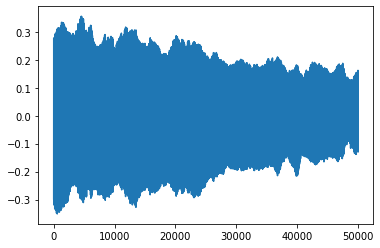

In [5]:
plt.plot(wav_slice)

In [6]:
W = 10000

In [7]:
def randints(n, k):
    return [random.randint(0, n-1) for _ in range(k)]

In [48]:
def d(t):
    autocorrelation = scipy.signal.convolve(wav_slice.numpy()[t:], wav_slice[t:t+W].numpy()[::-1], mode='valid')
    energy = scipy.signal.convolve(wav_slice.numpy()[t:] * wav_slice.numpy()[t:], np.ones(W), mode='valid')
    distance = (energy + energy[0]) - (2 * autocorrelation)
    return distance

In [50]:
def normalized_d(t):
    sum_ = 0
    ret = []
    for tau, dist in enumerate(d(t)):
        if tau == 0:
            ret.append(1)
        else:
            ret.append(dist / ((1/tau) * sum_))
        sum_ += dist
    return np.array(ret)

In [102]:
def pitch(x_threshold=5, y_threshold=0.25, iterations=10):
    pitch_candidates = []
    for t in randints(W, iterations):
        ls = normalized_d(t)
        for x, val in enumerate(ls):
            if x > x_threshold and val < y_threshold and ls[x+1] < val:
                pitch_candidates.append(sample_rate / x)
                break
    median = np.median(pitch_candidates)
    return median if median in pitch_candidates else pitch_candidates[0]

In [113]:
pitch()

561.4035087719299

In [104]:
base = np.arange(0, 2 ** 15).astype(np.float64)
amplitude = 1
def get_frequency(frequency):
    c = (frequency * 2 * np.pi) / sample_rate
    wavelet_ = amplitude * np.sin(c * base)
    return wavelet_

In [114]:
wav_slice = wav[:50000]
Audio(wav_slice, rate=sample_rate)

In [115]:
Audio(get_frequency(pitch()), rate=sample_rate)